# Marble Signatures: classification

The following is intended to be part of the documentation of central backend functionality of the Marble Signatures project:
A Jupyter Notebook is chosen to provide an interactive medium for communicating  the exact procedures used for classifying data input to the website.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# Confidence Ellipses

The following code allows drawing confidence ellipses and is taken from: https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html

In [21]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

The following generates a demo plot of three marble classes and one test sample input. 

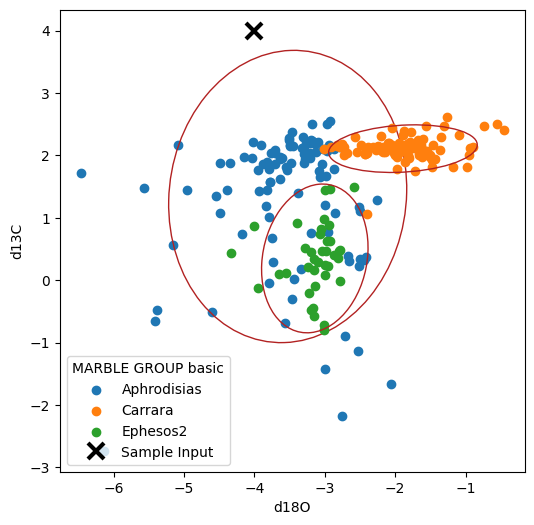

In [22]:
db = pd.read_excel('1_DB_Basic_dec_24.xlsx')

classes = db["MARBLE GROUP basic"].unique()

# Demo: Filtering for classes beginning with A or alphabetically before Ephesos2
filtered_classes = [c for c in classes if 
                    c == 'Carrara' or 
                    c == 'Aphrodisias' or 
                    c == 'Ephesos2']

fig, ax = plt.subplots(figsize=(6, 6))

# scaling factor for 90 % confidence ellipses, following this page https://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/
# in the confidence ellipse algorithm, each axis is scaled by 2 * n_std * standard_deviation
n_std = np.sqrt(4.605)

for class_name in filtered_classes:
    class_mask = db["MARBLE GROUP basic"] == class_name
    plt.scatter(
        db.loc[class_mask, "d18O"], 
        db.loc[class_mask, "d13C"], 
        label=class_name)
    confidence_ellipse(
        db.loc[class_mask, "d18O"], 
        db.loc[class_mask, "d13C"],  
        ax, 
        n_std=n_std, 
        edgecolor='firebrick')
    
test_values = [[-4, 4]]
plt.plot(test_values[0][0], test_values[0][1], "kx", label="Sample Input", ms=12, mew=3)
plt.xlabel('d18O')
plt.ylabel('d13C')
plt.legend(title='MARBLE GROUP basic')
plt.show()

# Relative Probability

This is showing the logic used to compute the relative probability in the app. 

In [23]:
class_mask = np.isin(db["MARBLE GROUP basic"], filtered_classes)
X = np.column_stack((db.loc[class_mask,"d18O"], db.loc[class_mask, "d13C"]))
y = np.array(db.loc[class_mask, "MARBLE GROUP basic"])
clf = LinearDiscriminantAnalysis()
clf.fit(X, y)
print("Predicted class:", clf.predict(test_values)[0], "\n")
print("Probabilities:")
print("-------------")
probabilities = clf.predict_proba(test_values)
for i in range(len(probabilities[0])):
    print(clf.classes_[i], ":", round(probabilities[0][i] * 100, 2), "%")

Predicted class: Aphrodisias 

Probabilities:
-------------
Aphrodisias : 93.66 %
Carrara : 6.3 %
Ephesos2 : 0.04 %


# Absolute probability

Below you can see the code and two examples of the absolute probability computation used in the app.

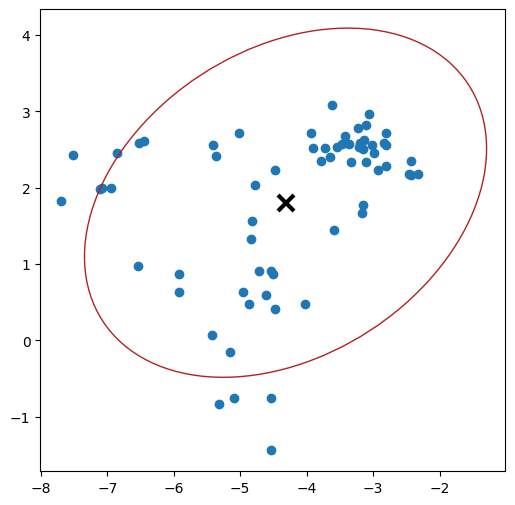

Absolute Probability for sample exactly at mean: 1.0


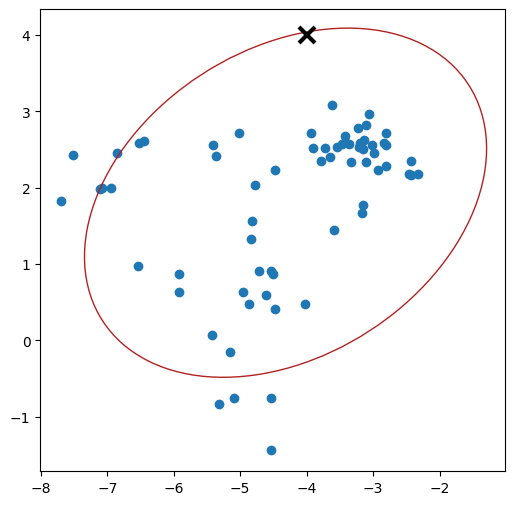

Absolute Probability for sample approx. at edge of confidence ellipse: 0.10873728471961663


In [24]:
from scipy.stats import chi2
from scipy.spatial import distance

def absolute_probability(x, y, sample):
    '''
    x: values of samples in x dimension
    y: values of samples in y dimension
    sample: two-dimensional data point, for which the abs. prob. will be computed
    
    returns: the absolute probability, ranging from 1 exactly in the mean to close to 0 far away from the data
    '''
    mean = (np.mean(x), np.mean(y))
    cov = np.cov(x, y)
    inv_cov = np.linalg.inv(cov)
    mahalanobis = distance.mahalanobis(sample, mean, inv_cov)

    survival_prob = 1 - chi2.cdf(mahalanobis**2, df=2)

    return survival_prob


# test
def demo_plot(X, sample):
    # demo scatter for one class
    fig, ax = plt.subplots(figsize=(6, 6))

    plt.scatter(X[:,0], X[:,1])

    # sample input
    plt.plot(sample[0], sample[1], "kx", label="Sample Input", ms=12, mew=3)

    # confidence ellipse
    confidence_ellipse(X[:,0], X[:,1], ax, np.sqrt(4.605), edgecolor='firebrick')
    plt.show()

class_mask = np.isin(db["MARBLE GROUP basic"], "Afyon")
X = np.column_stack((db.loc[class_mask,"d18O"], db.loc[class_mask, "d13C"]))
test_values = [[np.mean(X[:,0]), np.mean(X[:,1])],
               [-4, 4]
               ]

demo_plot(X, test_values[0])
print("Absolute Probability for sample exactly at mean:", absolute_probability(X[:,0], X[:,1], sample=test_values[0]))

demo_plot(X, test_values[1])
print("Absolute Probability for sample approx. at edge of confidence ellipse:", 
      absolute_probability(X[:,0], X[:,1], sample=test_values[1]))